In [1]:
import time
from pprint import pprint
# from math import round
from multiprocessing import Pool

from IPython.display import display

from pylab import *

from numpy import *
from scipy.sparse import *
from scipy.sparse.linalg import spsolve

$$\varepsilon \frac{d^{2}}{d t^{2}} u{\left(t \right)}
+\left(\varepsilon^{2} + 1\right) \frac{d}{d t} u{\left(t \right)}
+ \left(1 - \varepsilon^{2}\right) u{\left(t \right)}=0$$
$u(0)=0, u(1)=1$
$$u{\left(t \right)} = \frac{\left(- e^{\dfrac{t}{\varepsilon}} + e^{t \left(\varepsilon + 2\right)}\right) e^{- \varepsilon t + \varepsilon - t + 1 - \frac{t}{\varepsilon} + \frac{1}{\varepsilon}}}{- e^{\dfrac{1}{\varepsilon}} + e^{\varepsilon + 2}}$$

In [2]:
def exact(t, eps):
    return (-exp(t/eps) + exp(t*(eps + 2)))\
           *exp(-eps*t + eps - t + 1 - t/eps + 1/eps)\
           /(-exp(1/eps) + exp(eps + 2))

In [3]:
N = 500*4
t = linspace(0., 1., num=N+1, endpoint=True, dtype=float64)
h = t[1] - t[0]

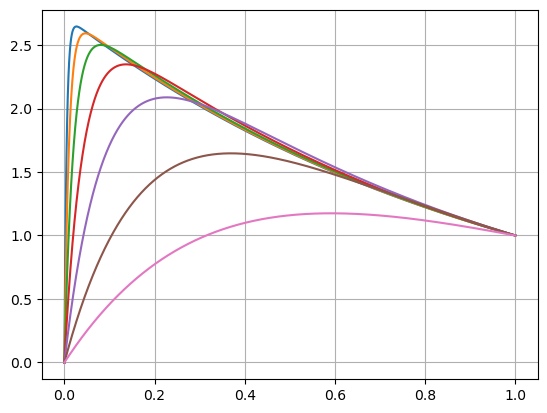

In [4]:
for i in range(7):
    eps = 0.005*2**i
    plot(t, exact(t, eps))
grid()

In [5]:
def boundaryLayer(t, eps, left, right):
    """
    t - время
    eps - параметр
    left - значение при при t[0]
    right - значение при при t[-1]
    """
    N, h = len(t), t[1] - t[0]
    h2, eps0, eps1 = h*h, 1 + eps**2, 1 - eps**2
    
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((2, N, 5), dtype=int32)
    col = zeros((2, N, 5), dtype=int32)
    data = zeros((2, N, 5), dtype=float64)    

    for j in range(N):
        row[0, j] = j
        row[1, j] = N+j

    col[0, 0, :1] = 0
    col[1, 0, :] = 0, 1, 2, 3, N
    for j in range(1, N-1):
        col[0, j, :4] = j-1, j, j+1, N+j
        col[1, j, :] = j-1, j+1, N+j-1, N+j, N+j+1
    col[0, -1, :1] = N-1
    col[1, -1, :] = N-4, N-3, N-2, N-1, 2*N-1

    data[0, 0, :1] = 1.
    # TODO eps
    data[1, 0, :] = eps0*30/h - eps1*4  + eps*48/h2,\
                    eps0*3/h  - eps1*41 - eps*84/h2,\
                   -eps0*30/h - eps1*14 + eps*24/h2,\
                   -eps0*3/h  - eps1    + eps*12/h2,\
                    eps0*6
    for j in range(1, N-1):
        data[0, j, :4] = eps*12/h2 + eps1 - eps0*3/h,\
                        -eps*24/h2 + eps1*10,\
                         eps*12/h2 + eps1 + eps0*3/h,\
                         eps0*6
        data[1, j, :] = 1/(2*h), -1/(2*h),\
                         1./6., 2./3., 1./6.
    data[0, -1, :1] = 1.
    data[1, -1, :] = eps0*3/h  - eps1    + eps*12/h2,\
                     eps0*30/h - eps1*14 + eps*24/h2,\
                    -eps0*3/h  - eps1*41 - eps*84/h2,\
                    -eps0*30/h - eps1*4  + eps*48/h2,\
                     eps0*6


    # столбец свободных членов
    b = zeros((2, N), dtype=float64)
    b[0, 0] = left
    b[0, -1] = right
    
    sol = spsolve(csr_matrix((data.reshape(2*N*5),\
                             (row.reshape(2*N*5), col.reshape(2*N*5))),\
                             shape=(2*N, 2*N)), b.reshape(2*N))

    return sol

In [6]:
res = []
for i in range(7):
    eps = 0.005*2**i
    sol = boundaryLayer(t, eps, 0., 1.)
    res.append(sol)

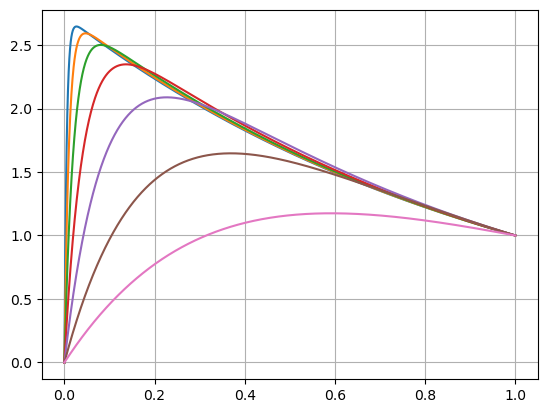

In [7]:
for i in range(7):
    eps = 0.005*2**i
#     plot(t, exact(t, eps))
    plot(t, res[i][:N+1])
grid()

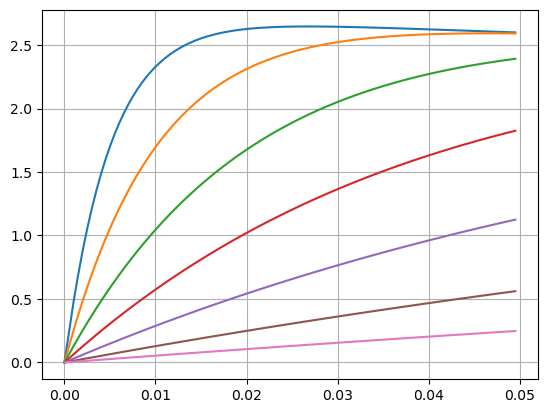

In [8]:
for i in range(7):
    eps = 0.005*2**i
#     plot(t, exact(t, eps))
    plot(t[:100], res[i][:N+1][:100])
grid()

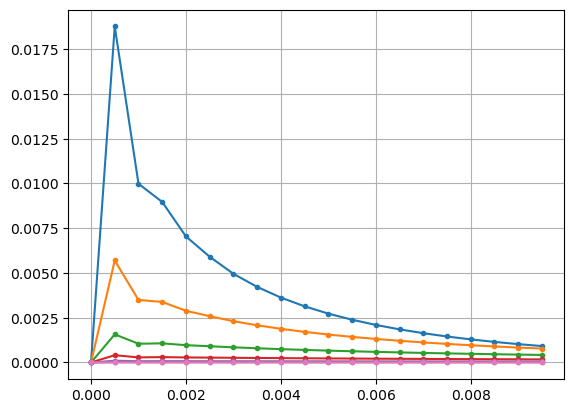

In [9]:
for i in range(7):
    eps = 0.005*2**i
    plot(t[:20], abs((res[i][:20] - exact(t, eps)[:20]))
         /(1. + abs(exact(t[:20], eps))), marker=".")
grid()